# Nutcracker 02: Lattice-Scale Analysis

**The right question:** Not "what fraction has small displacement?" but "what fraction has L1 = 0 in lattice coordinates?"

The bf16 lattice IS the physics. Tokens don't freeze because displacements are small—they freeze when the displacement rounds to zero in bf16. This notebook tracks:

1. **Per-token lattice displacement** (ΔW′) at each step
2. **L1 and L∞ norms** to detect phase transitions
3. **Phase boundaries** per token: Early → Midlife → Late → Fimbulwinter
4. **Weight decay comparison** on transition *timing*, not just final counts

## Phase Definitions (from lore/lifecycle-phases.md)

| Phase | Criterion | Character |
|-------|-----------|-----------|
| **Early** | ‖ΔW′‖₂ > √D | Multi-cell jumps |
| **Midlife** | L∞ > 1 | Local but vigorous |
| **Late** | L∞ ≤ 1 | Adjacent-cell motion only |
| **Fimbulwinter** | L1 = 0 sustained | Frozen |

## Parameters

In [9]:
import torch

# Paths
GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

# Architecture: Rich
N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
DROPOUT = 0.0

# Training
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
MODEL_DTYPE = torch.bfloat16
TRAINING_STEPS = 6000

# Experiment
WEIGHT_DECAY_VALUES = [0.01, 0.0]

# Phase transition thresholds
SQRT_D = (D_MODEL ** 0.5)  # ~11.3 for D=128

# Reproducibility
RANDOM_SEED = 42

## Imports & Device

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
from tokenizers import Tokenizer
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Dtype: {MODEL_DTYPE}")
print(f"√D = {SQRT_D:.2f}")

Device: mps
Dtype: torch.bfloat16
√D = 11.31


## Lattice Displacement Functions

From `lore/lattice-scale.md` — compute ULP and lattice displacement ΔW′.

In [11]:
def compute_ulp_bf16(tensor_bf16: torch.Tensor) -> torch.Tensor:
    """
    Compute the ULP (Unit in Last Place) for each element of a bfloat16 tensor.
    Returns a float32 tensor of ULP values (on same device as input).
    """
    original_device = tensor_bf16.device
    
    # MPS doesn't support uint16, so we do bit manipulation on CPU
    tensor_cpu = tensor_bf16.cpu()
    bits = tensor_cpu.view(torch.uint16).to(torch.int32)
    
    # Extract exponent (bits 7-14, 8 bits)
    exponent = ((bits >> 7) & 0xFF).to(torch.int32)
    
    # Normal numbers: ULP = 2^(E - 134)
    # Subnormals (E=0): ULP = 2^(-133) — treat E=0 as E=1
    effective_exp = torch.where(exponent == 0, torch.ones_like(exponent), exponent)
    
    ulp = torch.pow(2.0, (effective_exp - 134).float())
    
    # Move back to original device
    return ulp.to(original_device)


def compute_lattice_displacement(W_before: torch.Tensor, W_after: torch.Tensor) -> torch.Tensor:
    """
    Compute per-dimension lattice displacement ΔW′.
    
    Args:
        W_before: bfloat16 weights at time t-1 [n_tokens, d_model]
        W_after: bfloat16 weights at time t [n_tokens, d_model]
    
    Returns:
        float32 tensor of lattice displacements [n_tokens, d_model]
    """
    delta_W = W_after.float() - W_before.float()  # Weight-space difference
    ulp = compute_ulp_bf16(W_before)              # ULP at starting position
    return delta_W / ulp                          # Lattice cells crossed


def compute_lattice_norms(delta_W_prime: torch.Tensor):
    """
    Compute L1, L2, L∞ norms of lattice displacement for each token.
    
    Args:
        delta_W_prime: [n_tokens, d_model] lattice displacements
    
    Returns:
        L1, L2, Linf: each [n_tokens] tensor
    """
    abs_delta = torch.abs(delta_W_prime)
    L1 = abs_delta.sum(dim=1)           # Total cells moved
    L2 = torch.norm(delta_W_prime, dim=1)  # Euclidean in lattice space
    Linf = abs_delta.max(dim=1).values  # Max single-dimension move
    return L1, L2, Linf


print("✓ Lattice functions defined (with MPS workaround)")
print(f"  Phase boundaries: Early (L2 > {SQRT_D:.1f}), Midlife (L∞ > 1), Late (L∞ ≤ 1), Fimbulwinter (L1 = 0)")

✓ Lattice functions defined (with MPS workaround)
  Phase boundaries: Early (L2 > 11.3), Midlife (L∞ > 1), Late (L∞ ≤ 1), Fimbulwinter (L1 = 0)


## Load Data

In [12]:
# Load tokenizer
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Tokenizer: {vocab_size:,} tokens")

# Load cached tokenized corpus
tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

# Load dead token census
with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = sorted(census['dead_token_ids'])  # Sorted for consistent ordering
n_dead = len(dead_token_ids)
print(f"✓ Dead tokens: {n_dead:,}")

✓ Tokenizer: 3,988 tokens
✓ Corpus: 34,993,926 tokens
✓ Dead tokens: 1,914


## Dataset & Model

In [13]:
class TokenDataset(Dataset):
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]


class GPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        return self.head(self.ln_f(h))


dataset = TokenDataset(all_tokens, SEQ_LEN)
print(f"✓ Dataset: {len(dataset):,} samples")

✓ Dataset: 100,000 samples


## Training with Full Lattice Tracking

In [14]:
def get_dead_embeddings(model, dead_ids):
    """Extract embeddings for dead tokens (in bf16)."""
    W = model.tok_emb.weight.detach()
    dead_ids_tensor = torch.tensor(dead_ids, device=W.device)
    return W[dead_ids_tensor].clone()


def train_with_lattice_tracking(weight_decay, training_steps, dead_ids, desc):
    """
    Train model and track per-token lattice metrics at each step.
    
    Returns:
        DataFrame with columns: step, token_idx, token_id, L1, L2, Linf, loss
    """
    n_dead = len(dead_ids)
    
    # Fresh model
    torch.manual_seed(RANDOM_SEED)
    model = GPT(
        vocab_size=vocab_size,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        n_layers=N_LAYERS,
        d_ff=D_FF,
        seq_len=SEQ_LEN,
        dropout=DROPOUT
    ).to(device).to(MODEL_DTYPE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    loader_iter = iter(loader)
    
    # We'll collect aggregate stats per step (full per-token data would be huge)
    step_records = []
    
    W_dead_prev = get_dead_embeddings(model, dead_ids)
    model.train()
    
    pbar = tqdm(range(training_steps), desc=desc)
    for step in pbar:
        try:
            x, y = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x, y = next(loader_iter)
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        
        # Compute lattice displacement
        W_dead_curr = get_dead_embeddings(model, dead_ids)
        delta_W_prime = compute_lattice_displacement(W_dead_prev, W_dead_curr)
        L1, L2, Linf = compute_lattice_norms(delta_W_prime)
        
        # Convert to numpy
        L1_np = L1.cpu().numpy()
        L2_np = L2.cpu().numpy()
        Linf_np = Linf.cpu().numpy()
        
        # Aggregate stats for this step
        n_frozen = (L1_np == 0).sum()  # L1 = 0 means truly frozen this step
        n_late = ((Linf_np <= 1) & (L1_np > 0)).sum()  # L∞ ≤ 1 but moving
        n_midlife = ((Linf_np > 1) & (L2_np <= SQRT_D)).sum()
        n_early = (L2_np > SQRT_D).sum()
        
        step_records.append({
            'step': step,
            'loss': loss.item(),
            'n_frozen': n_frozen,
            'n_late': n_late,
            'n_midlife': n_midlife,
            'n_early': n_early,
            'frac_frozen': n_frozen / n_dead,
            'frac_late': n_late / n_dead,
            'frac_midlife': n_midlife / n_dead,
            'frac_early': n_early / n_dead,
            'mean_L1': L1_np.mean(),
            'mean_L2': L2_np.mean(),
            'mean_Linf': Linf_np.mean(),
            'median_L1': np.median(L1_np),
            'max_L1': L1_np.max(),
        })
        
        W_dead_prev = W_dead_curr
        
        if step % 100 == 0:
            pbar.set_postfix(
                frozen=f"{100*n_frozen/n_dead:.0f}%",
                late=f"{100*n_late/n_dead:.0f}%",
                loss=f"{loss.item():.3f}"
            )
    
    return pd.DataFrame(step_records)


print("✓ Training function defined")

✓ Training function defined


## Run Experiment

In [15]:
print("="*70)
print("NUTCRACKER: LATTICE-SCALE ANALYSIS")
print("="*70)
print(f"Training {TRAINING_STEPS:,} steps")
print(f"Tracking {n_dead:,} dead tokens in lattice coordinates")
print(f"Phase thresholds: Early (L2 > {SQRT_D:.1f}), Late (L∞ ≤ 1), Frozen (L1 = 0)")
print()

results = {}

for wd in WEIGHT_DECAY_VALUES:
    label = f"wd={wd}" if wd > 0 else "wd=0 (no decay)"
    print(f"\n{'='*60}")
    print(f"{label}")
    print(f"{'='*60}")
    
    if device == 'mps':
        torch.mps.empty_cache()
    
    df = train_with_lattice_tracking(wd, TRAINING_STEPS, dead_token_ids, label)
    df['weight_decay'] = wd
    results[wd] = df
    
    print(f"\n  Final state:")
    print(f"    Frozen (L1=0): {100*df.iloc[-1]['frac_frozen']:.1f}%")
    print(f"    Late (L∞≤1):   {100*df.iloc[-1]['frac_late']:.1f}%")
    print(f"    Midlife:       {100*df.iloc[-1]['frac_midlife']:.1f}%")
    print(f"    Early:         {100*df.iloc[-1]['frac_early']:.1f}%")

print("\n" + "="*70)
print("✓ Experiment complete")
print("="*70)

NUTCRACKER: LATTICE-SCALE ANALYSIS
Training 6,000 steps
Tracking 1,914 dead tokens in lattice coordinates
Phase thresholds: Early (L2 > 11.3), Late (L∞ ≤ 1), Frozen (L1 = 0)


wd=0.01


wd=0.01:   0%|          | 0/6000 [00:00<?, ?it/s]


  Final state:
    Frozen (L1=0): 97.5%
    Late (L∞≤1):   1.9%
    Midlife:       0.5%
    Early:         0.0%

wd=0 (no decay)


wd=0 (no decay):   0%|          | 0/6000 [00:00<?, ?it/s]


  Final state:
    Frozen (L1=0): 97.5%
    Late (L∞≤1):   1.9%
    Midlife:       0.5%
    Early:         0.0%

✓ Experiment complete


## Visualize Phase Distribution Over Time

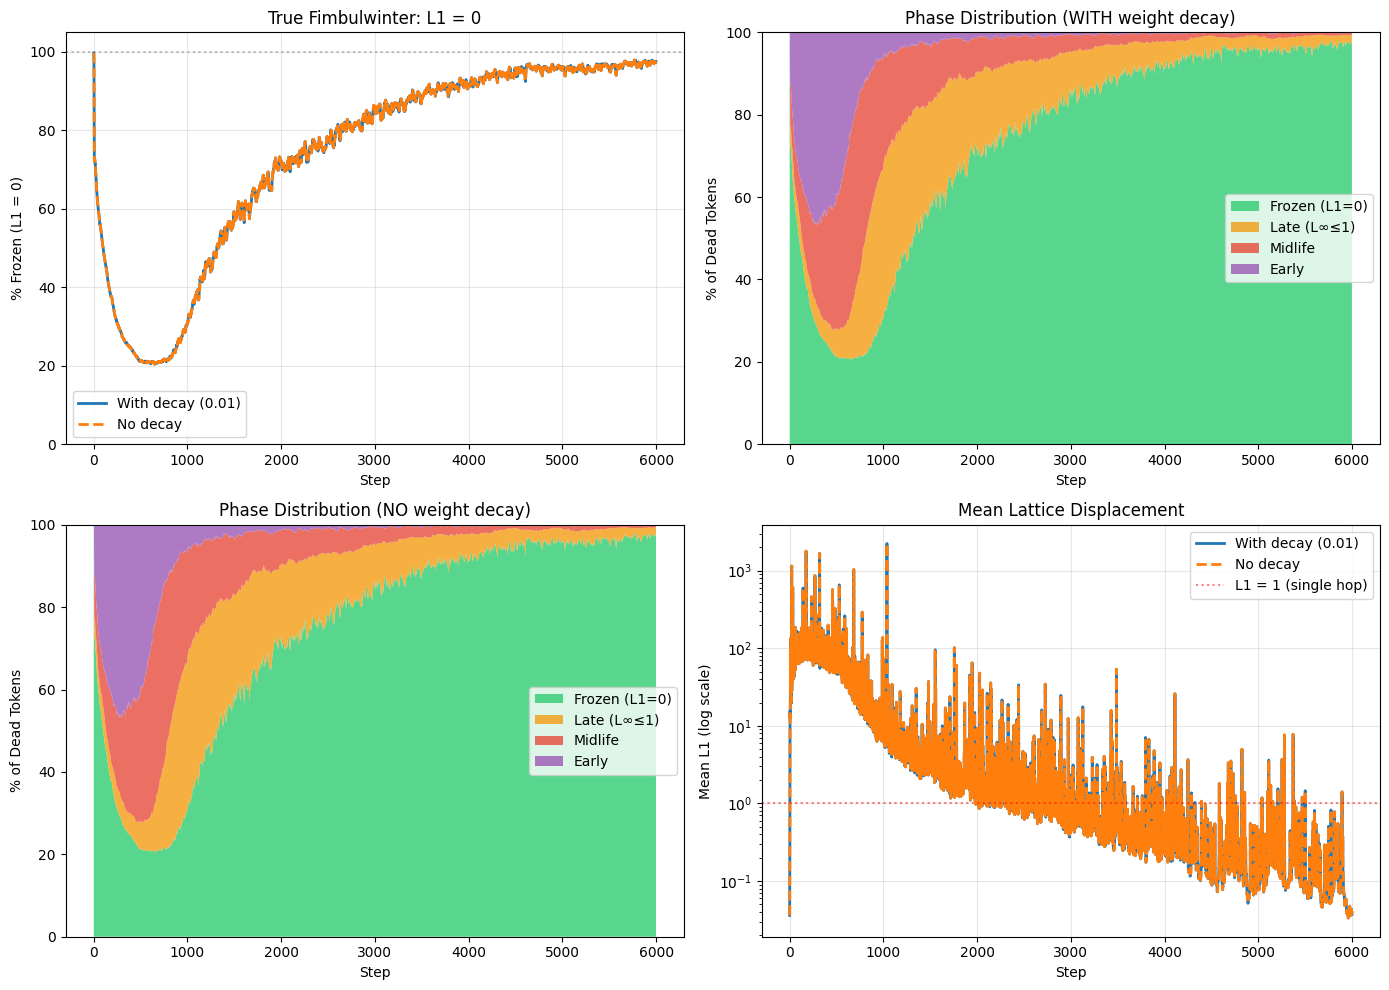

✓ Saved: lattice_analysis@200.png, lattice_analysis@72.png


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'frozen': '#2ecc71', 'late': '#f39c12', 'midlife': '#e74c3c', 'early': '#9b59b6'}
wd_styles = {0.01: '-', 0.0: '--'}
wd_labels = {0.01: 'With decay (0.01)', 0.0: 'No decay'}

# Top left: Frozen fraction comparison
ax1 = axes[0, 0]
for wd, df in results.items():
    ax1.plot(df['step'], 100*df['frac_frozen'], 
             linestyle=wd_styles[wd], linewidth=2, label=wd_labels[wd])
ax1.axhline(100, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Step')
ax1.set_ylabel('% Frozen (L1 = 0)')
ax1.set_title('True Fimbulwinter: L1 = 0')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# Top right: Stacked phase distribution (with decay)
ax2 = axes[0, 1]
df_wd = results[0.01]
ax2.stackplot(df_wd['step'], 
              100*df_wd['frac_frozen'],
              100*df_wd['frac_late'],
              100*df_wd['frac_midlife'],
              100*df_wd['frac_early'],
              labels=['Frozen (L1=0)', 'Late (L∞≤1)', 'Midlife', 'Early'],
              colors=[colors['frozen'], colors['late'], colors['midlife'], colors['early']],
              alpha=0.8)
ax2.set_xlabel('Step')
ax2.set_ylabel('% of Dead Tokens')
ax2.set_title('Phase Distribution (WITH weight decay)')
ax2.legend(loc='center right')
ax2.set_ylim(0, 100)

# Bottom left: Stacked phase distribution (no decay)
ax3 = axes[1, 0]
df_no = results[0.0]
ax3.stackplot(df_no['step'],
              100*df_no['frac_frozen'],
              100*df_no['frac_late'],
              100*df_no['frac_midlife'],
              100*df_no['frac_early'],
              labels=['Frozen (L1=0)', 'Late (L∞≤1)', 'Midlife', 'Early'],
              colors=[colors['frozen'], colors['late'], colors['midlife'], colors['early']],
              alpha=0.8)
ax3.set_xlabel('Step')
ax3.set_ylabel('% of Dead Tokens')
ax3.set_title('Phase Distribution (NO weight decay)')
ax3.legend(loc='center right')
ax3.set_ylim(0, 100)

# Bottom right: Mean L1 over time (log scale)
ax4 = axes[1, 1]
for wd, df in results.items():
    ax4.semilogy(df['step'], df['mean_L1'], 
                 linestyle=wd_styles[wd], linewidth=2, label=wd_labels[wd])
ax4.axhline(1, color='red', linestyle=':', alpha=0.5, label='L1 = 1 (single hop)')
ax4.set_xlabel('Step')
ax4.set_ylabel('Mean L1 (log scale)')
ax4.set_title('Mean Lattice Displacement')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lattice_analysis@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('lattice_analysis@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: lattice_analysis@200.png, lattice_analysis@72.png")

## Export Data

In [17]:
# Combine results
df_all = pd.concat(results.values(), ignore_index=True)

# Save to CSV
csv_path = 'lattice_analysis_results.csv'
df_all.to_csv(csv_path, index=False)
print(f"✓ Saved {len(df_all):,} rows to {csv_path}")

# Summary stats
print("\nFinal state comparison:")
final = df_all.groupby('weight_decay').last()[['frac_frozen', 'frac_late', 'frac_midlife', 'frac_early', 'mean_L1']]
print(final.round(4))

✓ Saved 12,000 rows to lattice_analysis_results.csv

Final state comparison:
              frac_frozen  frac_late  frac_midlife  frac_early  mean_L1
weight_decay                                                           
0.00               0.9754     0.0193        0.0052         0.0   0.0371
0.01               0.9754     0.0193        0.0052         0.0   0.0371


## Detailed Comparison

In [18]:
print("\n" + "="*70)
print("DETAILED COMPARISON")
print("="*70)

# Compare frozen fraction at key milestones
milestones = [1000, 2000, 3000, 4000, 5000, 6000]
print("\nFrozen fraction (L1=0) at milestones:")
print(f"{'Step':>6} | {'With decay':>12} | {'No decay':>12} | {'Difference':>12}")
print("-"*50)

for step in milestones:
    if step <= TRAINING_STEPS:
        wd_frozen = results[0.01][results[0.01]['step'] == step-1]['frac_frozen'].values[0]
        no_frozen = results[0.0][results[0.0]['step'] == step-1]['frac_frozen'].values[0]
        diff = no_frozen - wd_frozen
        print(f"{step:>6} | {100*wd_frozen:>11.1f}% | {100*no_frozen:>11.1f}% | {100*diff:>+11.2f}%")

# Are they meaningfully different?
print("\n" + "*"*70)
final_wd = results[0.01].iloc[-1]['frac_frozen']
final_no = results[0.0].iloc[-1]['frac_frozen']
diff = final_no - final_wd

if abs(diff) < 0.01:
    print("❓ INCONCLUSIVE: Difference < 1%")
    print(f"   Weight decay has no measurable effect on freezing.")
elif diff > 0.05:
    print("★ WEIGHT DECAY IMPEDES FREEZING ★")
    print(f"   No-decay reaches {100*final_no:.1f}% frozen vs {100*final_wd:.1f}% with decay.")
elif diff < -0.05:
    print("⚡ UNEXPECTED: Weight decay HELPS freezing?")
    print(f"   With-decay reaches {100*final_wd:.1f}% frozen vs {100*final_no:.1f}% without.")
else:
    print(f"⚖ SMALL DIFFERENCE: {100*abs(diff):.1f}% difference")
    print(f"   May need longer training or more sensitive analysis.")
print("*"*70)


DETAILED COMPARISON

Frozen fraction (L1=0) at milestones:
  Step |   With decay |     No decay |   Difference
--------------------------------------------------
  1000 |        30.8% |        30.8% |       +0.00%
  2000 |        72.1% |        72.1% |       +0.00%
  3000 |        84.8% |        84.8% |       +0.00%
  4000 |        91.5% |        91.5% |       +0.00%
  5000 |        95.6% |        95.6% |       +0.00%
  6000 |        97.5% |        97.5% |       +0.00%

**********************************************************************
❓ INCONCLUSIVE: Difference < 1%
   Weight decay has no measurable effect on freezing.
**********************************************************************
